In [1]:
!pip install gymnasium
!pip install "gymnasium[atari,accept-rom-license]"
!pip install "gymnasium[accept-rom-license
!apt-get install -y swig
!pip install grid2op
!pip install lightsim2grid
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.6 MB/s eta 0:00:00
/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 2s (478 kB/s)
Selecting previously un

In [18]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import threading
import multiprocessing
import matplotlib.pyplot as plt
import grid2op
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward
from lightsim2grid import LightSimBackend
from collections import defaultdict

class Gym2OpEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward

        p = Parameters()
        p.MAX_SUB_CHANGED = 4
        p.MAX_LINE_STATUS_CHANGED = 4

        self._g2op_env = grid2op.make(
            self._env_name, backend=self._backend, test=False,
            action_class=action_class, observation_class=observation_class,
            reward_class=reward_class, param=p
        )

        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

    def setup_observations(self):
        obs = self._g2op_env.reset()

        self.obs_components = [
            ("rho", obs.rho),
            ("line_status", obs.line_status),
            ("actual_dispatch", obs.actual_dispatch),
            ("load_p", obs.load_p),
            ("load_q", obs.load_q),
            ("topo_vect", obs.topo_vect),
            ("time_before_cooldown_line", obs.time_before_cooldown_line),
            ("time_before_cooldown_sub", obs.time_before_cooldown_sub),
        ]

        total_size = sum(component[1].size for component in self.obs_components)

        self.observation_space = gym.spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(total_size,),
            dtype=np.float32
        )

        print(f"Observation space defined with {total_size} features.")

    def _format_observation(self, obs):
        # Return observation as a dictionary to align with Gym2OpEnv
        return {
            "rho": obs.rho,
            "load_p": obs.load_p,
            "gen_p": obs.gen_p
        }

    def setup_actions(self):
        num_substations = self._g2op_env.n_sub
        num_lines = self._g2op_env.n_line

        self.action_space = gym.spaces.Discrete(num_lines + num_substations + 1)
        print(f"Action space defined with {self.action_space.n} discrete actions corresponding to lines, substations, and do nothing.")

    def reset(self, seed=None):
        g2op_obs = self._g2op_env.reset(seed=seed)
        obs = self._format_observation(g2op_obs)
        return obs, {}

    def step(self, action):
        g2op_action = self._convert_action(action)
        g2op_obs, reward, done, info = self._g2op_env.step(g2op_action)
        obs = self._format_observation(g2op_obs)
        truncated = False
        return obs, reward, done, truncated, info

    def _convert_action(self, gym_action):
        if gym_action == 0:  # Do nothing
            return self._g2op_env.action_space()
        else:
            line_id = (gym_action - 1) // 2
            new_status = 1 if (gym_action - 1) % 2 == 0 else -1
            return self._g2op_env.action_space({"set_line_status": [(line_id, new_status)]})

    def render(self):
        return self._g2op_env.render()

In [4]:
def plot_evaluation_rewards(total_rewards, agent_name):
    plt.figure(figsize=(12, 6))
    plt.plot(total_rewards, label='Total Reward per Episode', marker='o')
    plt.title(f"{agent_name} Evaluation: Total Rewards per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.axhline(y=np.mean(total_rewards), color='r', linestyle='--', label='Average Reward')
    plt.legend()
    plt.grid()
    plt.savefig(f"{agent_name}_evaluation.png")
    plt.show()

def plot_rewards(rewards, agent_name):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title('Q-Learning Agent Performance')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.savefig(f"{agent_name}_performance.png")
    plt.show()


def plot_smoothed_performance(episode_rewards,agent_name, smooth_factor=0.1):
    plt.figure(figsize=(12, 6))

    # Plot raw data
    episodes = range(len(episode_rewards))
    plt.plot(episodes, episode_rewards, alpha=0.3, color='blue', label='Raw')

    # Plot smoothed data
    smoothed_rewards = []
    for i, reward in enumerate(episode_rewards):
        if i == 0:
            smoothed_rewards.append(reward)
        else:
            previous = smoothed_rewards[-1]
            smoothed_rewards.append(previous * (1 - smooth_factor) + reward * smooth_factor)

    plt.plot(episodes, smoothed_rewards, linewidth=2, color='blue', label='Smoothed')

    plt.title(f"{agent_name} Performance: Total Rewards per Episode")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{agent_name} smoothed_performance.png")
    plt.show()

In [5]:
def evaluate_agent(env, agent,agent_name, n_episodes=100, max_steps=100):
    total_rewards = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        state = agent.discretize_state(obs)
        total_reward = 0
        done = False
        step = 0

        while not done and step < max_steps:
            action = agent.get_action(state)  # Use the trained agent's policy
            next_obs, reward, terminated, truncated, info = env.step(action)
            next_state = agent.discretize_state(next_obs)
            done = terminated or truncated

            total_reward += reward
            state = next_state
            step += 1

        total_rewards.append(total_reward)

        # Print the episode summary
        print(f"Episode {episode + 1}/{n_episodes}: Total Reward = {total_reward}")

    avg_reward = np.mean(total_rewards)
    print(f"Average Reward over {n_episodes} episodes: {avg_reward}")

    # Plotting the evaluation rewards
    plot_evaluation_rewards(total_rewards,agent_name)

    return total_rewards
# plotting the rewards

In [3]:
def run_experiment(env_name, agent_name, train_func_name, allowed_actions=None, max_steps=100):
    # Step 1: Dynamically load environment, agent, and training function
    gymEnv = globals()[env_name]
    agentImplementation = globals()[agent_name]
    train_func = globals()[train_func_name]

    # Step 2: Initialize the environment and agent
    env = gymEnv()
    # Call agent with high_impact_actions if provied
    if allowed_actions is not None:
        agent = agentImplementation(env, allowed_actions = allowed_actions)
    else:
        agent = agentImplementation(env)



    print("#####################")
    print("# OBSERVATION SPACE #")
    print("#####################")
    print(env.observation_space)
    print("#####################\n")
    print("#####################")
    print("#   ACTION SPACE    #")
    print("#####################")
    print(env.action_space)
    print("#####################\n\n")

    print("# Training the agent #")
    rewards = train_func(env, agent)
    plot_rewards(rewards,agent_name)
    plot_smoothed_performance(rewards,agent_name)

    print("\n#####################")
    print("#  Evaluating the agent #")
    print("#####################")

    # Evaluate the trained agent
    evaluate_agent(env, agent, agent_name)

    print("\n#####################")
    print("#  Testing the agent #")
    print("#####################")

    # Test the trained agent
    obs, info = env.reset()
    state = agent.discretize_state(obs)
    total_reward = 0
    done = False
    max_steps = 100
    step = 0

    print(f"step = {step} (reset):")
    print(f"\t obs = {obs}")
    print(f"\t info = {info}\n\n")

    while not done and step < max_steps:
        action = agent.get_action(state)
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_state = agent.discretize_state(next_obs)
        done = terminated or truncated

        step += 1
        total_reward += reward

        print(f"step = {step}: ")
        print(f"\t obs = {next_obs}")
        print(f"\t reward = {reward}")
        print(f"\t terminated = {terminated}")
        print(f"\t truncated = {truncated}")
        print(f"\t info = {info}")

        # Check if the action is valid
        is_action_valid = not (info.get("is_illegal", False) or info.get("is_ambiguous", False))
        print(f"\t is action valid = {is_action_valid}")
        if not is_action_valid:
            print(f"\t\t reason = {info.get('exception', 'Unknown')}")
        print("\n")

        state = next_state

    print("###########")
    print("# SUMMARY #")
    print("###########")
    print(f"Total Reward: {total_reward}")
    print(f"Total Steps: {step}")
    print("###########")


**Agents and improvements**

In [14]:
# The Q- Learning Algorithm
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.95, epsilon=0.1):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))

    def get_action(self, state):
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state, done):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action] * (not done)
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.lr * td_error

    def discretize_state(self, observation):
        rho = observation["rho"]
        load_p = observation["load_p"]
        gen_p = observation["gen_p"]

        # Discretize rho (line capacity usage)
        rho_discrete = tuple(np.digitize(rho, bins=[0.1, 0.5, 0.8, 1.0, 1.2]))

        # Discretize load_p (active load)
        load_p_discrete = tuple(np.digitize(load_p, bins=[50, 100, 150, 200]))

        # Discretize gen_p (active generation)
        gen_p_discrete = tuple(np.digitize(gen_p, bins=[50, 100, 150, 200, 250]))

        return (rho_discrete, load_p_discrete, gen_p_discrete)

def train_agent(env, agent, n_episodes=1000, max_steps=100):
    episode_rewards = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        state = agent.discretize_state(obs)
        total_reward = 0
        done = False
        step = 0

        while not done and step < max_steps:
            action = agent.get_action(state)
            next_obs, reward, terminated, truncated, info = env.step(action)
            next_state = agent.discretize_state(next_obs)
            done = terminated or truncated

            agent.update(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward
            step += 1

        episode_rewards.append(total_reward)
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"Episode {episode + 1}: Average Reward (last 10 episodes): {avg_reward:.2f}")

    return episode_rewards

In [17]:
class QLearningAgent_Imprv_1:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon  # Initial exploration rate
        self.epsilon_min = epsilon_min  # Minimum exploration rate
        self.epsilon_decay = epsilon_decay  # Decay rate for epsilon
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))

    def get_action(self, state):
        # Use epsilon-greedy policy with decaying epsilon
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def update_epsilon(self):
        # Apply decay to epsilon, down to epsilon_min
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update(self, state, action, reward, next_state, done):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action] * (not done)
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.lr * td_error

    def discretize_state(self, observation):
        rho = observation["rho"]
        load_p = observation["load_p"]
        gen_p = observation["gen_p"]

        # Discretize rho (line capacity usage)
        rho_discrete = tuple(np.digitize(rho, bins=[0.1, 0.5, 0.8, 1.0, 1.2]))

        # Discretize load_p (active load)
        load_p_discrete = tuple(np.digitize(load_p, bins=[50, 100, 150, 200]))

        # Discretize gen_p (active generation)
        gen_p_discrete = tuple(np.digitize(gen_p, bins=[50, 100, 150, 200, 250]))

        return (rho_discrete, load_p_discrete, gen_p_discrete)


def train_agent_Imprv_1(env, agent, n_episodes=1000, max_steps=100):
    episode_rewards = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        state = agent.discretize_state(obs)
        total_reward = 0
        done = False
        step = 0

        while not done and step < max_steps:
            action = agent.get_action(state)
            next_obs, reward, terminated, truncated, info = env.step(action)
            next_state = agent.discretize_state(next_obs)
            done = terminated or truncated

            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step += 1

        # Decay epsilon at the end of each episode
        agent.update_epsilon()

        episode_rewards.append(total_reward)
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"Episode {episode + 1}: Average Reward (last 10 episodes): {avg_reward:.2f}")

    return episode_rewards


We use `test_action_impact` to get actions with hight rewards:

`[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]`

In [19]:
def test_action_impact(env):
    env = env()
    obs = env.reset()
    action_space = env._g2op_env.action_space  # Grid2Op action space

    # Test impact of toggling each line status
    for line_id in range(env._g2op_env.n_line):
        # Toggle the line's status
        action = action_space({"set_line_status": [(line_id, 1)]})  # Turn on line or change its status

        # Execute the action and observe results
        next_obs, reward, done, info = env._g2op_env.step(action)  # Direct step with Grid2Op environment
        print(f"Line {line_id} Action | Reward: {reward}, Done: {done}, Line Status: {next_obs.line_status[line_id]}")

        # Reset if the episode ends
        if done:
            obs = env.reset()
test_action_impact(env=Gym2OpEnv)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Observation space defined with 159 features.
Action space defined with 35 discrete actions corresponding to lines, substations, and do nothing.
Line 0 Action | Reward: 0.35103216767311096, Done: False, Line Status: True
Line 1 Action | Reward: 0.3539615571498871, Done: False, Line Status: True
Line 2 Action | Reward: 0.3547111451625824, Done: False, Line Status: True
Line 3 Action | Reward: 0.354891300201416, Done: False, Line Status: True
Line 4 Action | Reward: 0.35786399245262146, Done: False, Line Status: True
Line 5 Action | Reward: 0.36076050996780396, Done: False, Line Status: True
Line 6 Action | Reward: 0.3628411293029785, Done: False, Line Status: True
Line 7 Action | Reward: 0.36724138259887695, Done: False, Line Status: True
Line 8 Action | Reward: 0.37210121750831604, Done: False, Line Status: True
Line 9 Action | Reward: 0.3702411651611328, Done: False, Line Status: True
Line 10 Action | Reward: 0.3771757185459137, Done: False, Line Status: True
Line 11 Action | Reward: 0

In [20]:
class QLearningAgent_Imprv_2:
    def __init__(self, env, allowed_actions, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.env = env
        self.allowed_actions = allowed_actions  # List of allowed high-impact actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Q-table will only store values for the allowed actions
        self.q_table = defaultdict(lambda: np.zeros(len(allowed_actions)))  # Adjusted to match the length of allowed actions

    def get_action(self, state):
        # Epsilon-greedy policy with restricted action space
        if np.random.random() < self.epsilon:
            return np.random.choice(self.allowed_actions)
        else:
            # Map allowed actions to Q-values and select the best one
            action_values = [self.q_table[state][idx] for idx in range(len(self.allowed_actions))]
            best_action_index = np.argmax(action_values)
            return self.allowed_actions[best_action_index]

    def update_epsilon(self):
        # Apply decay to epsilon, down to epsilon_min
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update(self, state, action, reward, next_state, done):
        # Translate action to index within the restricted space
        action_index = self.allowed_actions.index(action)  # Find index of action in allowed_actions
        best_next_action_index = np.argmax([self.q_table[next_state][i] for i in range(len(self.allowed_actions))])

        # Calculate TD target and update Q-table using restricted action indices
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action_index] * (not done)
        td_error = td_target - self.q_table[state][action_index]
        self.q_table[state][action_index] += self.lr * td_error

    def discretize_state(self, observation):
        rho = observation["rho"]
        load_p = observation["load_p"]
        gen_p = observation["gen_p"]

        # Discretize rho (line capacity usage)
        rho_discrete = tuple(np.digitize(rho, bins=[0.1, 0.5, 0.8, 1.0, 1.2]))

        # Discretize load_p (active load)
        load_p_discrete = tuple(np.digitize(load_p, bins=[50, 100, 150, 200]))

        # Discretize gen_p (active generation)
        gen_p_discrete = tuple(np.digitize(gen_p, bins=[50, 100, 150, 200, 250]))

        return (rho_discrete, load_p_discrete, gen_p_discrete)


def train_agent_Imprv_2(env, agent, n_episodes=1000, max_steps=100):
    episode_rewards = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        state = agent.discretize_state(obs)
        total_reward = 0
        done = False
        step = 0

        while not done and step < max_steps:
            # Select an action from the restricted action space
            action = agent.get_action(state)

            # Execute the action in the environment
            next_obs, reward, terminated, truncated, info = env.step(action)
            next_state = agent.discretize_state(next_obs)
            done = terminated or truncated

            # Update the Q-table with the chosen action
            agent.update(state, action, reward, next_state, done)

            # Update state and accumulate reward
            state = next_state
            total_reward += reward
            step += 1

        # Decay epsilon at the end of each episode to gradually reduce exploration
        agent.update_epsilon()

        # Track total reward for the episode
        episode_rewards.append(total_reward)
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"Episode {episode + 1}: Average Reward (last 10 episodes): {avg_reward:.2f}")

    return episode_rewards

In [21]:
class QLearningAgent_Imprv_3:
    def __init__(self, env, allowed_actions, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.env = env
        self.allowed_actions = allowed_actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Q-table aligned with allowed actions
        self.q_table = defaultdict(lambda: np.zeros(len(allowed_actions)))

    def get_action(self, state):
        # Epsilon-greedy policy with restricted action space
        if np.random.random() < self.epsilon:
            return np.random.choice(self.allowed_actions)
        else:
            # Map allowed actions to Q-values and select the best one
            action_values = [self.q_table[state][idx] for idx in range(len(self.allowed_actions))]
            best_action_index = np.argmax(action_values)
            return self.allowed_actions[best_action_index]

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update(self, state, action, reward, next_state, done):
        action_index = self.allowed_actions.index(action)
        best_next_action_index = np.argmax([self.q_table[next_state][i] for i in range(len(self.allowed_actions))])

        # Update Q-value
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action_index] * (not done)
        td_error = td_target - self.q_table[state][action_index]
        self.q_table[state][action_index] += self.lr * td_error

    def discretize_state(self, observation):
        # Enhanced discretization for `rho`, `load_p`, and `gen_p`
        rho = observation["rho"]
        load_p = observation["load_p"]
        gen_p = observation["gen_p"]

        # Finer bins for rho (line loading)
        rho_discrete = tuple(np.digitize(rho, bins=[0.05, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.5]))

        # Finer bins for load_p (load power)
        load_p_discrete = tuple(np.digitize(load_p, bins=[25, 75, 125, 175, 225, 275]))

        # Finer bins for gen_p (generation power)
        gen_p_discrete = tuple(np.digitize(gen_p, bins=[25, 75, 125, 175, 225, 275, 325, 375]))

        # Return the discretized state as a tuple
        return (rho_discrete, load_p_discrete, gen_p_discrete)

def train_agent_Imprv_3(env, agent, n_episodes=1000, max_steps=100):
    episode_rewards = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        state = agent.discretize_state(obs)  # Use the refined discretization
        total_reward = 0
        done = False
        step = 0

        while not done and step < max_steps:
            # Select an action from the restricted action space
            action = agent.get_action(state)

            # Execute the action in the environment
            next_obs, reward, terminated, truncated, info = env.step(action)
            next_state = agent.discretize_state(next_obs)  # Refined discretization for next state
            done = terminated or truncated

            # Update the Q-table with the chosen action
            agent.update(state, action, reward, next_state, done)

            # Update state and accumulate reward
            state = next_state
            total_reward += reward
            step += 1

        # Decay epsilon at the end of each episode to gradually reduce exploration
        agent.update_epsilon()

        # Track total reward for the episode
        episode_rewards.append(total_reward)
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"Episode {episode + 1}: Average Reward (last 10 episodes): {avg_reward:.2f}")

    return episode_rewards




In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np

class DQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class QLearningAgent_Imprv_4:
    def __init__(self, env, allowed_actions, learning_rate=0.001, discount_factor=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, buffer_size=10000, batch_size=64, target_update_freq=10):
        self.env = env
        self.allowed_actions = allowed_actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        # Define the DQN architecture with correct input dimension
        input_dim = 37  # Total features based on `rho` (20) + `load_p` (11) + `gen_p` (6)
        output_dim = len(allowed_actions)
        self.policy_net = DQNetwork(input_dim, output_dim)
        self.target_net = DQNetwork(input_dim, output_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.replay_buffer = deque(maxlen=buffer_size)
        self.step_count = 0

    def get_action(self, state):
        # Epsilon-greedy policy for action selection
        if np.random.random() < self.epsilon:
            return random.choice(self.allowed_actions)
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.policy_net(state)
                action_index = q_values.argmax().item()
                return self.allowed_actions[action_index]

    def store_transition(self, state, action, reward, next_state, done):
        # Map action to its index in allowed_actions
        action_index = self.allowed_actions.index(action)
        self.replay_buffer.append((state, action_index, reward, next_state, done))

    def update_epsilon(self):
        # Apply epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train_step(self):
        # Only proceed if we have enough samples in the replay buffer
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample a mini-batch from the replay buffer
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert batch to tensors
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Get Q-values for current states and selected actions
        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Compute target Q-values using the target network
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute loss and update the policy network
        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network periodically
        self.step_count += 1
        if self.step_count % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def discretize_state(self, observation):
        #Extract and concatenate relevant observation components
        rho = observation["rho"].flatten()         # line loading
        load_p = observation["load_p"].flatten()   # active load power
        gen_p = observation["gen_p"].flatten()     # generated power

        #Concatenate all components into a single state vector
        state = np.concatenate([rho, load_p, gen_p]).astype(np.float32)
        return state




def train_DQN(env, agent, n_episodes=1000, max_steps=100):
    episode_rewards = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        state = agent.discretize_state(obs)  # Process initial observation into state
        total_reward = 0
        done = False
        step = 0

        while not done and step < max_steps:
            # Select action using epsilon-greedy policy
            action = agent.get_action(state)

            # Execute the action in the environment
            next_obs, reward, terminated, truncated, info = env.step(action)
            next_state = agent.discretize_state(next_obs)
            done = terminated or truncated

            # Store the transition in the replay buffer
            agent.store_transition(state, action, reward, next_state, done)

            # Train the DQN with a batch from the replay buffer
            agent.train_step()

            # Update the state and accumulate reward
            state = next_state
            total_reward += reward
            step += 1

        # Decay epsilon after each episode
        agent.update_epsilon()

        # Track total reward for the episode
        episode_rewards.append(total_reward)
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"Episode {episode + 1}: Average Reward (last 10 episodes): {avg_reward:.2f}")

    return episode_rewards

In [ ]:

run_experiment(
    env_name='Gym2OpEnv',  # Replace with the environment's class name as a string
    agent_name='QLearningAgent',         # The name of the Actor-Critic agent class
    train_func_name='train_agent',   # The name of the training function for the actor-critic agent
    allowed_actions=None,                   # Pass allowed actions if required, else None
    max_steps=100                           # Set max steps per episode
)

In [ ]:

run_experiment(
    env_name='Gym2OpEnv',  # Replace with the environment's class name as a string
    agent_name='QLearningAgent_Imprv_1',         # The name of the Actor-Critic agent class
    train_func_name='train_agent_Imprv_1',   # The name of the training function for the actor-critic agent
    allowed_actions=None,                   # Pass allowed actions if required, else None
    max_steps=100                           # Set max steps per episode
)

In [ ]:
impact_action = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
run_experiment(
    env_name='Gym2OpEnv',  # Replace with the environment's class name as a string
    agent_name='QLearningAgent_Imprv_2',         # The name of the Actor-Critic agent class
    train_func_name='train_agent_Imprv_2',   # The name of the training function for the actor-critic agent
    allowed_actions=impact_action,                   # Pass allowed actions if required, else None
    max_steps=100                           # Set max steps per episode
)

In [ ]:
impact_action = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
run_experiment(
    env_name='Gym2OpEnv',  # Replace with the environment's class name as a string
    agent_name='QLearningAgent_Imprv_3',         # The name of the Actor-Critic agent class
    train_func_name='train_agent_Imprv_3',   # The name of the training function for the actor-critic agent
    allowed_actions=impact_action,                   # Pass allowed actions if required, else None
    max_steps=100                           # Set max steps per episode
)

Observation space defined with 159 features.
Action space defined with 35 discrete actions corresponding to lines, substations, and do nothing.
#####################
# OBSERVATION SPACE #
#####################
Box(-inf, inf, (159,), float32)
#####################

#####################
#   ACTION SPACE    #
#####################
Discrete(35)
#####################


# Training the agent #
Episode 10: Average Reward (last 10 episodes): 3.16
Episode 20: Average Reward (last 10 episodes): 3.62
Episode 30: Average Reward (last 10 episodes): 3.45
Episode 40: Average Reward (last 10 episodes): 2.87
Episode 50: Average Reward (last 10 episodes): 4.61
Episode 60: Average Reward (last 10 episodes): 4.74
Episode 70: Average Reward (last 10 episodes): 8.65
Episode 80: Average Reward (last 10 episodes): 3.66
Episode 90: Average Reward (last 10 episodes): 2.94
Episode 100: Average Reward (last 10 episodes): 7.07
Episode 110: Average Reward (last 10 episodes): 3.99
Episode 120: Average Reward (last 1

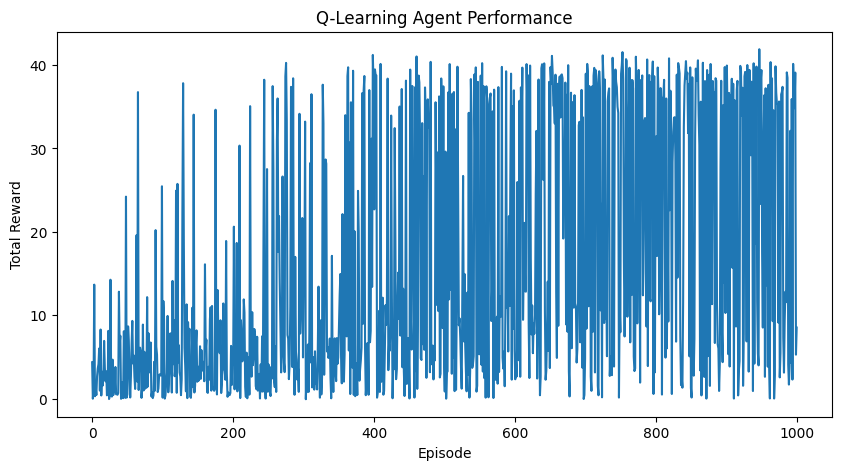

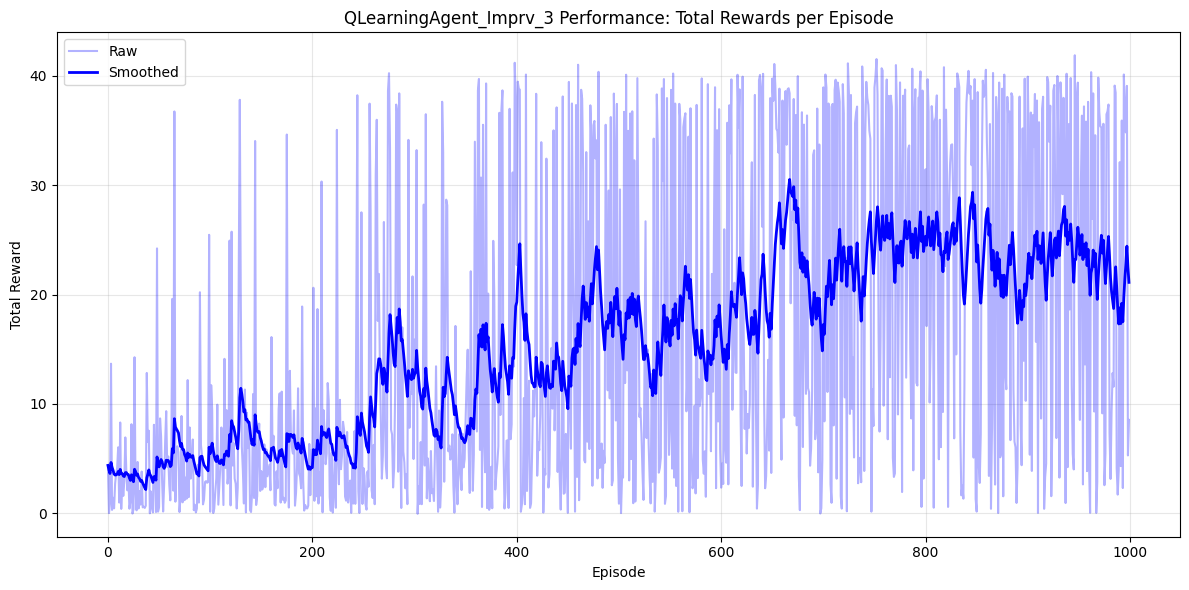


#####################
#  Evaluating the agent #
#####################
Episode 1/100: Total Reward = 39.863726019859314
Episode 2/100: Total Reward = 35.52662995457649
Episode 3/100: Total Reward = 39.61127224564552
Episode 4/100: Total Reward = 36.97049939632416
Episode 5/100: Total Reward = 4.421922743320465
Episode 6/100: Total Reward = 0.05397897958755493
Episode 7/100: Total Reward = 3.5413862466812134
Episode 8/100: Total Reward = 9.94374480843544
Episode 9/100: Total Reward = 30.894749611616135
Episode 10/100: Total Reward = 39.00101625919342
Episode 11/100: Total Reward = 37.35391581058502
Episode 12/100: Total Reward = 38.60629138350487
Episode 13/100: Total Reward = 37.65163138508797
Episode 14/100: Total Reward = 38.20178997516632
Episode 15/100: Total Reward = 38.55712440609932
Episode 16/100: Total Reward = 38.49509972333908
Episode 17/100: Total Reward = 10.128049790859222
Episode 18/100: Total Reward = 37.588094651699066
Episode 19/100: Total Reward = 3.648631662130356
E

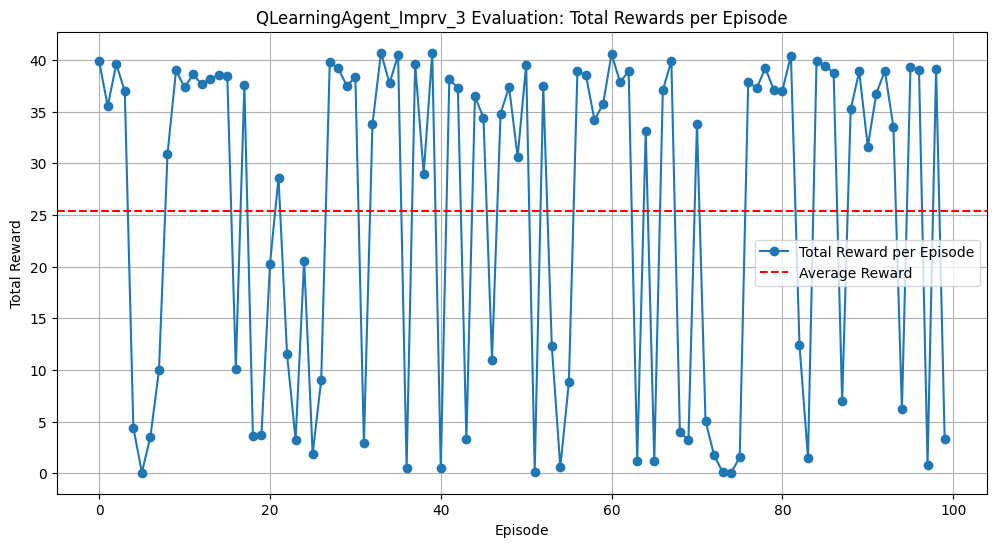


#####################
#  Testing the agent #
#####################
step = 0 (reset):
	 obs = {'rho': array([0.30887657, 0.27841836, 0.29162294, 0.21537623, 0.59384626,
       0.17306098, 0.43695855, 0.7361563 , 0.5409613 , 0.83255094,
       0.21089828, 0.2799631 , 0.4399437 , 0.5355879 , 0.528021  ,
       0.4155138 , 0.37718698, 0.32304877, 0.47112474, 0.35708132],
      dtype=float32), 'load_p': array([22.4, 86.9, 46. ,  7.2, 12.1, 28.8,  9.2,  3.5,  5.7, 12.8, 15.1],
      dtype=float32), 'gen_p': array([69.4   , 68.7   , 46.    ,  0.    ,  0.    , 69.1372],
      dtype=float32)}
	 info = {}


step = 1: 
	 obs = {'rho': array([0.30343887, 0.27528092, 0.29859564, 0.21408115, 0.58870757,
       0.16632389, 0.43765664, 0.72839886, 0.5397036 , 0.83002985,
       0.21229371, 0.27834833, 0.43405932, 0.53231514, 0.5172248 ,
       0.40902185, 0.3680827 , 0.30949906, 0.46454826, 0.346798  ],
      dtype=float32), 'load_p': array([22.8, 88.3, 45.8,  7.1, 12. , 28.1,  9.1,  3.5,  5.7, 13. ,

In [25]:
impact_action = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
run_experiment(
    env_name='Gym2OpEnv',  # Replace with the environment's class name as a string
    agent_name='QLearningAgent_Imprv_4',         # The name of the Actor-Critic agent class
    train_func_name='train_agent_Imprv_4',   # The name of the training function for the actor-critic agent
    allowed_actions=impact_action,                   # Pass allowed actions if required, else None
    max_steps=100                           # Set max steps per episode
)